<a href="https://colab.research.google.com/github/AlexanderPalencia/Neural-Network-for-NIDS/blob/main/IDSNeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso de redes neuronales en NIDS (Network Instruction Detection System) aplicado en configuración de IPS (intrusion prevention system)

In [1]:
# General tool for data analisys and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

import requests


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer, OrdinalEncoder
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

2.4.1


In [2]:
!pip install PyDrive

### GPU use for neural network training

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':"1HoWqSIxtPWJjgaINK9IJ95ioXu65lj6P"})   # replace the id with id of file you want to access
downloaded.GetContentFile('X_train_kdd.csv')        
downloaded1 = drive.CreateFile({'id':"1Fup4d720mJnoHoYfPFN8WjlQMGBkVe_0"})   # replace the id with id of file you want to access
downloaded1.GetContentFile('y_train_kdd.csv')    
downloaded2 = drive.CreateFile({'id':"121UigMcQk2Xz8y2fpFEd7R43YSCyRPfi"})   # replace the id with id of file you want to access
downloaded2.GetContentFile('X_test_kdd.csv')    
downloaded3 = drive.CreateFile({'id':"11noDMlLzhhKNkGuP95XWqOdlajT6Qfx-"})   # replace the id with id of file you want to access
downloaded3.GetContentFile('y_test_kdd.csv')    
downloaded4 = drive.CreateFile({'id':"1n22Wm5yV2VFuwtPCkcP7KkIXJKKG6kkB"})   # replace the id with id of file you want to access
downloaded4.GetContentFile('validation_set.csv')   

In [6]:
X_train = pd.read_csv('X_train_kdd.csv')
X_test = pd.read_csv('X_test_kdd.csv')
y_train = pd.read_csv('y_train_kdd.csv', header=None)
y_test = pd.read_csv('y_test_kdd.csv', header=None)
validation_set = pd.read_csv('validation_set.csv')

In [7]:
print("Size of the training dataset \nRows : {} \nColumns : {}".format(X_train.shape[0],X_train.shape[1]))
print("Size of the training target variable " + str(y_train.shape))
print("Size of the testing dataset \nRows : {} \nColumns : {}".format(X_test.shape[0],X_test.shape[1]))

Size of the training dataset 
Rows : 345814 
Columns : 118
Size of the training target variable (345814, 1)
Size of the testing dataset 
Rows : 148206 
Columns : 118


In [8]:
# create model with most common parameters 
def arch_1():
    model = Sequential()
    w_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
    model.add(Dense(X_train.shape[1], input_dim = X_train.shape[1], activation = 'relu', kernel_initializer = w_initializer))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  
    return model

## Training the neural network without balancing the data set
### Predicting the value 0 means that the connection is a threat to the network and if it is 1 it is a normal connection


In [ ]:
nn_arch_1 = arch_1()
nn_arch_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
train_nn_1 = nn_arch_1.fit(X_train,y_train, epochs=30, batch_size=2000)

In [14]:
# predict the X test set
predictions_nn_1 = nn_arch_1.predict(X_test)
rounded = [round(x[0]) for x in predictions_nn_1]
df_pred = pd.DataFrame({'y_Actual':y_test[0], 'y_Predicted':rounded, 'Correct': y_test[0] == rounded})
df_pred.head()

,y_Actual,y_Predicted,Correct
0,0,0,True
1,0,0,True
2,0,0,True
3,1,1,True
4,0,0,True


In [19]:
print(classification_report(rounded, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    119477
           1       0.97      0.99      0.98     28729

    accuracy                           0.99    148206
   macro avg       0.98      0.99      0.99    148206
weighted avg       0.99      0.99      0.99    148206



In [18]:
confu = df_pred.loc[:, df_pred.columns != 'Correct']
confusion_matrix = pd.crosstab(confu['y_Actual'], confu['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted       0      1
Actual                  
0          118637    289
1             840  28440


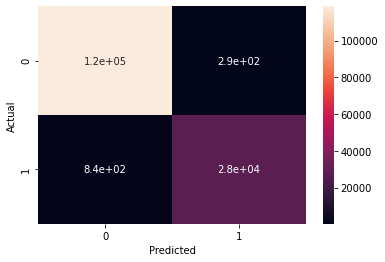

In [20]:
sns.heatmap(confusion_matrix, annot=True)
plt.show()

### We realize that the imbalance of the target variable is not afecting too much.
### Checking for overfitting


In [40]:
_, train_acc = nn_arch_1.evaluate(X_train, y_train, verbose=0)
_, test_acc = nn_arch_1.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.993, Test: 0.992


## Balancing the data set

In [23]:
downloaded5 = drive.CreateFile({'id':"12_RjNW-ESV8OQJz367daaLZGwWzycNDo"})   # replace the id with id of file you want to access
downloaded5.GetContentFile('all_kdd.csv')  

In [24]:
df = pd.read_csv('all_kdd.csv')
df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,target_type,...,service-nnsp,service-nntp,service-ntp_u,service-other,service-pm_dump,service-pop_2,service-pop_3,service-printer,service-private,service-red_i,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH
0,0,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,59,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [25]:
from sklearn.utils import resample
# Checking for imbalance in the dataset
print("Unbalance Dataset")
print(df['threat_conn'].value_counts())

# Balancing the dataset
df_majority = df[df.threat_conn==0]
df_minority = df[df.threat_conn==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results

df_final = pd.concat([df_majority_downsampled, df_minority])
 
print(df_final.threat_conn.value_counts())

Unbalance Dataset
0    396743
1     97277
Name: threat_conn, dtype: int64
1    97277
0    97277
Name: threat_conn, dtype: int64


In [26]:
# Machine Learning
X_balance = df_final.drop(['target','target_type', 'threat_conn'], axis=1)
y_balance = df_final['threat_conn']
print("Size of x dataset " + str(X_balance.shape))
print("Size of y dataset " + str(y_balance.shape))

Size of x dataset (194554, 118)
Size of y dataset (194554,)


In [27]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_balance, y_balance, test_size=0.3, random_state=42)
print("Size of the training dataset \nRows : {} \nColumns : {}".format(X_train_b.shape[0],X_train_b.shape[1]))
print("Size of the training target variable " + str(y_train_b.shape))
print("Size of the testing dataset \nRows : {} \nColumns : {}".format(X_test_b.shape[0],X_test_b.shape[1]))

Size of the training dataset 
Rows : 136187 
Columns : 118
Size of the training target variable (136187,)
Size of the testing dataset 
Rows : 58367 
Columns : 118


In [28]:
y_train_b.value_counts()

0    68141
1    68046
Name: threat_conn, dtype: int64

In [ ]:
nn_balance = arch_1()
nn_balance.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_balance.fit(X_train_b, y_train_b, epochs=10)

In [32]:
# predict the X test set
predictions_nn_1 = nn_balance.predict(X_test)
rounded = [round(x[0]) for x in predictions_nn_1]
df_pred = pd.DataFrame({'y_Actual':y_test[0], 'y_Predicted':rounded, 'Correct': y_test[0] == rounded})
df_pred.head()

,y_Actual,y_Predicted,Correct
0,0,0,True
1,0,0,True
2,0,0,True
3,1,1,True
4,0,0,True


In [37]:
print(classification_report(rounded, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    118537
           1       1.00      0.98      0.99     29669

    accuracy                           1.00    148206
   macro avg       1.00      0.99      0.99    148206
weighted avg       1.00      1.00      1.00    148206



In [34]:
confu = df_pred.loc[:, df_pred.columns != 'Correct']
confusion_matrix = pd.crosstab(confu['y_Actual'], confu['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted       0      1
Actual                  
0          118407    519
1             130  29150


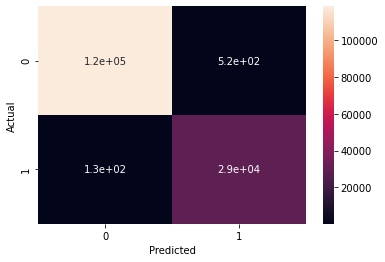

In [36]:
sns.heatmap(confusion_matrix, annot=True)
plt.show()

### Check for overfitting

In [39]:
_, train_acc = nn_balance.evaluate(X_train_b, y_train_b, verbose=0)
_, test_acc = nn_balance.evaluate(X_test_b, y_test_b, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.996, Test: 0.996


# Checking which model best predicts based on completely new values ​​is to say that the model has never seen these values.

In [46]:
downloaded6 = drive.CreateFile({'id':"1GhWRmSwViu1rYFYn0RE4dclA9z476Efa"})   # replace the id with id of file you want to access
downloaded6.GetContentFile('y_ml_validation.csv')  

In [47]:
y_validation_set = pd.read_csv('y_ml_validation.csv')
validation_set.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type-icmp,protocol_type-tcp,...,service-nnsp,service-nntp,service-ntp_u,service-other,service-pm_dump,service-pop_2,service-pop_3,service-printer,service-private,service-red_i,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH
0,0,190,1630,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,6,0.0,0.0,0.0,0.17,1.0,0.0,0.33,255,248,0.97,0.01,0.00,0.00,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.00,1.0,0.0,0.00,255,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.00,1.0,0.0,0.00,255,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,308,1434,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,32,32,0.0,0.0,0.0,0.00,1.0,0.0,0.00,78,255,1.00,0.00,0.01,0.02,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.00,1.0,0.0,0.00,255,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [48]:
y_validation_set.head()

,threat_conn
0,1
1,1
2,0
3,0
4,0


## Predicting the values ​​with the neural network that was balanced.


In [64]:
predictions_new_balance = nn_balance.predict(validation_set)
rounded = [round(x[0]) for x in predictions_new_balance]
a = rounded[:311028]
df_pred = pd.DataFrame({'y_Actual':y_validation_set['threat_conn'], 'y_Predicted':a, 'Correct': y_validation_set['threat_conn'] == a})
print(classification_report(a, y_validation_set['threat_conn']))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80    249018
           1       0.20      0.20      0.20     62010

    accuracy                           0.68    311028
   macro avg       0.50      0.50      0.50    311028
weighted avg       0.68      0.68      0.68    311028



In [65]:
confu = df_pred.loc[:, df_pred.columns != 'Correct']
confusion_matrix = pd.crosstab(confu['y_Actual'], confu['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted       0      1
Actual                  
0          200565  49871
1           48453  12139


In [67]:
predictions_new_balance = nn_arch_1.predict(validation_set)
rounded = [round(x[0]) for x in predictions_new_balance]
a = rounded[:311028]
df_pred = pd.DataFrame({'y_Actual':y_validation_set['threat_conn'], 'y_Predicted':a, 'Correct': y_validation_set['threat_conn'] == a})
print(classification_report(a, y_validation_set['threat_conn']))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81    250942
           1       0.19      0.20      0.20     60086

    accuracy                           0.69    311028
   macro avg       0.50      0.50      0.50    311028
weighted avg       0.69      0.69      0.69    311028



In [68]:
confu = df_pred.loc[:, df_pred.columns != 'Correct']
confusion_matrix = pd.crosstab(confu['y_Actual'], confu['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted       0      1
Actual                  
0          202137  48299
1           48805  11787


# Conclusions
* Our best model is the one we train without the data without balancer, although it is not much we show that it is better at predicting values ​​that you have never seen.
